<a href="https://colab.research.google.com/github/aseddin/F22_ECE4715/blob/main/5_classification_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification metrics

In [1]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# figure saving function
from pathlib import Path
IMAGES_PATH = Path() / "images" / "classification_metrics"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

# Load the Iris plants datasest

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris(as_frame=False) 

# split the data into train/test datasets
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=42, stratify=iris.target
)

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
np.unique(y_train)

array([0, 1, 2])

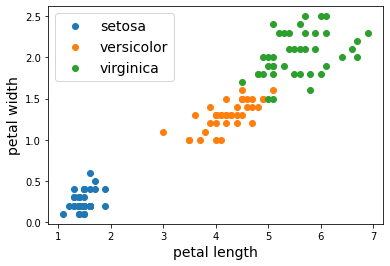

In [5]:
for c in np.unique(y_train):
  plt.scatter(X_train[:, 2][y_train == c], 
              X_train[:, 3][y_train == c], 
              label=iris.target_names[c])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend()
plt.show()

## Binary Classifier
Let's simplify the problem by only identifying one of the classes "virginica". In other words, we make it a binary classification problem where we are trying to classify an input as belonging to "virginica" or not 

In [6]:
y_train_virginica = (y_train == 2).astype(np.int8) # returns 0s and 1s not True/False
y_test_virginica = (y_test == 2).astype(np.int8)

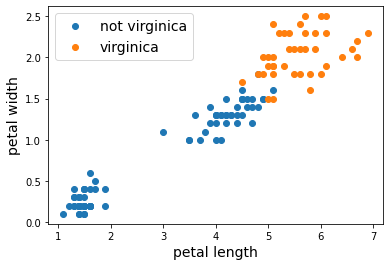

In [7]:
virginica_target_names = ["not virginica", "virginica"]
for c in np.unique(y_train_virginica):
  plt.scatter(X_train[:, 2][y_train_virginica == c], 
              X_train[:, 3][y_train_virginica == c], 
              label=virginica_target_names[c])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend()
plt.show()

In [8]:
# train a classifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train_virginica)
qda_clf.score(X_train, y_train_virginica)

0.9583333333333334

In [9]:
i = 119
print("predicted:", qda_clf.predict([X_train[i, :]]))
print("true label:", y_train_virginica[i])

predicted: [0]
true label: 0


## Performance Measures

In `sklearn` estimators have a `score` method that provides a default evaluation criterion for the problem they solve. 

According to the [QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) documentation page, `score(X, y[, sample_weight])` "Return the mean accuracy on the given test data and labels." 

### Accuracy

In [10]:
qda_clf.score(X_train, y_train_virginica)

0.9583333333333334

A better way to evaluate a model is to use cross-validation. By default, the `cross_val_score` uses the estimator's default scorer. 

For the QDA classifier, it will be the mean accuracy

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(qda_clf, X_train, y_train_virginica, cv=4)
scores

array([0.96666667, 0.96666667, 0.93333333, 0.96666667])

In [12]:
scores.mean()

0.9583333333333334

The accuracy numbers look good. 

But before we continue. Let's train a classifier that always select the most frequent class in the training set (in our case not virginica). In other words, it always select one of the classes regardless of the input

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_virginica)


DummyClassifier()

In [14]:
# Is there any virginica flowers?
print(any(dummy_clf.predict(X_train))) 

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_virginica, cv=4)

array([0.66666667, 0.66666667, 0.66666667, 0.66666667])

66% accuracy is simply because 2/3 of the training set were not virginica and the dummy classifier correctly classified all of them by always guessing that an input is not virginica.

This shows why we might want to use metrics other than accuracy when measuring classifiers performance. This is especially true when you have unbalanced datasets (i.e. some classes are much more frequent than others)

### Confusion Matrix

To construct a confusion matrix, we need a set of predictions to compare to actual targets. Preferably, the predictions should be for instances not seen during training. One way to get such "out-of-sample" or "clean" predictions without using the test set is to use `cross_val_predict` which is similar to `cross_val_score` but instead of computing the scores over K-fold cross-validation it yields "clean" predictions for each instance in the training set

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_virginica_pred = cross_val_predict(qda_clf, X_train, y_train_virginica,
                                           cv=4)

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_virginica, y_train_virginica_pred)
cm

array([[78,  2],
       [ 3, 37]])

In [18]:
# perfect classifier
confusion_matrix(y_train_virginica, y_train_virginica)

array([[80,  0],
       [ 0, 40]])

In [19]:
TN = cm[0, 0] # True Negative
FP = cm[0, 1] # False Positive
FN = cm[1, 0] # False Negative
TP = cm[1, 1] # True Positive

In [20]:
# accuracy
a = (TP + TN) / (TN + FP + FN + TP)
a

0.9583333333333334

#### Precision

Computed from positives only. Measures what fraction of detections are actually positive or measures the accuracy of the positive predictions
$$
\text{precision} = \frac{TP}{TP + FP}
$$

In [21]:
p = TP / (TP + FP)
p

0.9487179487179487

No need to remember the equations, `sklearn.metrics` contains many of them

In [22]:
from sklearn.metrics import precision_score
precision_score(y_train_virginica, y_train_virginica_pred)

0.9487179487179487

We can cheat this metric by training a classifier that classifies only 1 instance as positive (the one it is most confident about) and the rest will be classified as negative:
$$
\text{precision} = \frac{1}{1 + 0} = 100\%
$$

Such a classifer is not very useful, this is why precision is usually used along with another metric called **recall**

#### Recall

The ratio of the true positives correctly detected by the classifier Also called sensitivity or true positive rate (TPR)

$$
\text{recall} = \frac{TP}{TP + FN}
$$

In [23]:
r = TP / (TP + FN)
r

0.925

In [24]:
from sklearn.metrics import recall_score
recall_score(y_train_virginica, y_train_virginica_pred)

0.925

#### Precision Recall Trade-Off

Look at the notes for a graphical explanation of the trade-off

In [25]:
# change i to test different input instances
i = 52

# increasing threshold should increase precision and decrease recall and vice versa
threshold = 0
p = qda_clf.predict([X_train[i, :]]) # predicted class
s = qda_clf.decision_function([X_train[i, :]]) # decision function score

print("predicted:", p)
print("true label:", y_train_virginica[i])

print("decision function score:", s)
print(f"prediction using threshold({threshold}):", s > threshold)

predicted: [1]
true label: 1
decision function score: [11.41694451]
prediction using threshold(0): [ True]


Let's plot precision and recall curves by comparing the decision function scores with different thresholds

In [26]:
# setting the method attribute to "decision_function" result in "clean" 
# decision function scores as opposed to class predictions
y_virginica_scores = cross_val_predict(qda_clf, X_train, y_train_virginica,
                                       method="decision_function", cv=4)

y_virginica_scores

array([-6.23134302e+01,  3.17030393e+00, -3.42897877e+00, -7.37890529e+01,
       -5.43323533e+00,  2.13843056e+00, -5.48895556e+00, -8.61439771e-01,
        5.80837319e+00,  3.17520321e+00,  4.06899433e+00, -3.49755363e+00,
       -8.46149027e+00, -9.00746412e+00, -8.26896788e+00, -6.82611861e+01,
       -9.02259370e+01,  1.02654493e+00,  5.93670967e-01, -8.11372193e+01,
       -1.09622184e+00, -9.06252883e+01,  3.18873674e+00, -6.78112493e+01,
       -1.04394247e+01,  5.29220573e-01,  2.08694039e+00, -7.17291668e+01,
        9.36618054e+00, -8.59248684e+01, -8.37038463e+01, -9.82836985e+00,
       -4.11216720e+00, -1.06182015e+02,  5.67470512e+00,  1.43185298e+01,
       -1.75410091e+01, -1.60477059e+00,  1.63278443e+01,  3.92307054e+00,
       -7.00251637e+01, -8.33725665e+00, -9.76319139e+01,  3.59317717e+00,
       -7.41846844e+01, -8.36861752e+01,  4.35371135e+00, -8.65083019e+01,
       -5.58903972e+01, -7.39180790e+01, -6.92632109e+01, -1.08476102e+01,
        1.23849059e+01, -

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_virginica, y_virginica_scores)

In [28]:
threshold = 0

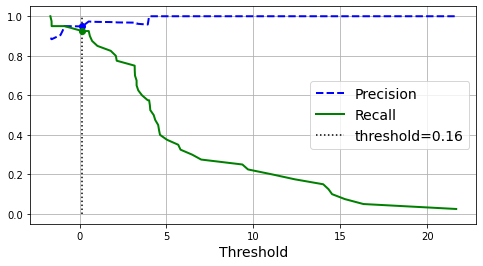

In [29]:
plt.figure(figsize=(8 ,4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

idx = (thresholds >= threshold).argmax() # first index >= threshold
actual_threshold = thresholds[idx]
plt.plot(actual_threshold, precisions[idx], "bo")
plt.plot(actual_threshold, recalls[idx], "go")
plt.vlines(actual_threshold, 0, 1.0, "k", "dotted", label="threshold={:.2f}".format(actual_threshold))
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

We can also plot recall VS precision

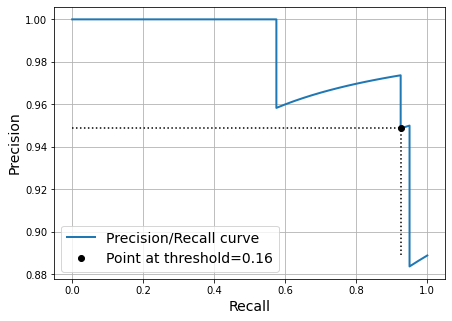

In [30]:
plt.figure(figsize=(7, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()


plt.plot([recalls[idx], recalls[idx]],
         [precisions[0], precisions[idx]], "k:")

plt.plot([0.0, recalls[idx]],
         [precisions[idx], precisions[idx]],
         "k:")

plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold={:.2f}".format(actual_threshold))

plt.legend(loc=("lower left"))

plt.show()


Hugging the top right is the best one can do.

Find the threshold for a specific precisions

In [31]:
needed_precisions = 0.965
idx_for_needed_precision =(precisions >= needed_precisions).argmax()
threshold = thresholds[idx_for_needed_precision]
y_virginica_threshold_predictions = y_virginica_scores >= threshold
print("threshold =", threshold)
print("precisions =", precision_score(y_train_virginica, y_virginica_threshold_predictions))
print("recall =", recall_score(y_train_virginica, y_virginica_threshold_predictions))

threshold = 0.5292205726937165
precisions = 0.9736842105263158
recall = 0.925


The previous code segments gives us the first threshold for the desired precision regardless of the recall. In the graph above you can see that precision is not monotonic and at precision of 0.96 there are 2 recall values, you might want to pick the threshold that gives you the higher precision and higher recall.

Remember, whenever you set a precision target, you should also ask yourself at what recall rate.

#### F-scores

For a fixed threshold, corresponding to a single point on the precision/recall curve, we can combine the precision and recall into a single value that tells us the quality of the classifier.

$$
F_{\beta} = (1 + \beta^2) 
    \frac{\text{precision} \times \text{recall}}
         {\beta^2 \text{precision} + \text{recall}}
$$

The value of $\beta$ can be interpreted as recall is $\beta$ more important than precision.

For example $\beta = 1$ means recall and precision have the same importance.

$$
F_1 = 2 \times
  \frac{\text{precision} \times \text{recall}}
         {\text{precision} + \text{recall}}
$$
Which is what we call the harmonic mean (as opposed to the arithmetic mean we are used to). Harmonic mean favors classifiers with higher and roughly equal precision and recall.

* $\beta = 0$ considers only precision
* $\beta \rightarrow \infty$ considers only recall
* $\beta < 1$ precision is more important than recall
* $\beta > 1$ recall is more imporant than precision

In [32]:
from sklearn.metrics import fbeta_score, f1_score

print("threshold =", threshold)
print("precisions =", precision_score(y_train_virginica, y_virginica_threshold_predictions))
print("recall =", recall_score(y_train_virginica, y_virginica_threshold_predictions))

print("F1 score=", f1_score(y_train_virginica, y_virginica_threshold_predictions))
print("Fbeta score (Beta = 1)=", fbeta_score(y_train_virginica, y_virginica_threshold_predictions, beta=1))
print("Fbeta score (Beta = 0.5)=", fbeta_score(y_train_virginica, y_virginica_threshold_predictions, beta=0.5))
print("Fbeta score (Beta = 2)=", fbeta_score(y_train_virginica, y_virginica_threshold_predictions, beta=2))


threshold = 0.5292205726937165
precisions = 0.9736842105263158
recall = 0.925
F1 score= 0.9487179487179489
Fbeta score (Beta = 1)= 0.9487179487179489
Fbeta score (Beta = 0.5)= 0.9635416666666666
Fbeta score (Beta = 2)= 0.9343434343434343


In [33]:
# show the value of F1 scores for different precision/recall combination
# the F1 score favors high and matching values of precision and recall
def my_f1score(p, r):
  if (p + r == 0):
    return 0
  else:
    return 2 * (p * r) / (p + r)

print("\t", end='')

for r in np.linspace(0, 1.0, 6):
  print("r={:.2f}".format(r),end='\t')

print()
print("-"*60)

for p in np.linspace(0, 1.0, 6):
  print("p={:.2f}|".format(p), end='\t')
  for r in np.linspace(0, 1.0, 6):
    print("  {:.2f}".format(my_f1score(p, r)), end='\t')
  print()


	r=0.00	r=0.20	r=0.40	r=0.60	r=0.80	r=1.00	
------------------------------------------------------------
p=0.00|	  0.00	  0.00	  0.00	  0.00	  0.00	  0.00	
p=0.20|	  0.00	  0.20	  0.27	  0.30	  0.32	  0.33	
p=0.40|	  0.00	  0.27	  0.40	  0.48	  0.53	  0.57	
p=0.60|	  0.00	  0.30	  0.48	  0.60	  0.69	  0.75	
p=0.80|	  0.00	  0.32	  0.53	  0.69	  0.80	  0.89	
p=1.00|	  0.00	  0.33	  0.57	  0.75	  0.89	  1.00	


#### The Receiver Operating Characteristic (ROC) Curve

Plot the True Positive Rate (TPR) also known as Recall vs the False Positive Rate (FPR) also known as Fallout at different thresholds.

$$
\text{recall} = \frac{TP}{TP + FN}
$$

FPR/Fallout is the ratio of negative instances that are incorrectly classified as positive.

$$
\text{False Positive Rate} = \frac{FP}{FP + TN}
$$

In [34]:
# similar to precision_recall_curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_virginica, y_virginica_scores)

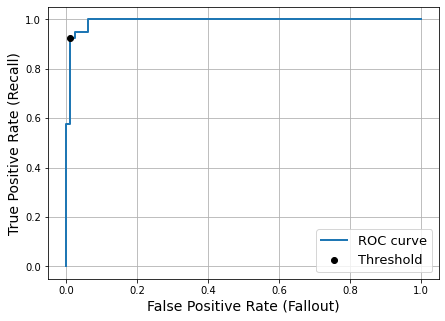

In [35]:
idx_for_threshold = (thresholds <= threshold).argmax()
tpr_at_threshold, fpr_at_threshold = tpr[idx_for_threshold], fpr[idx_for_threshold]

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([fpr_at_threshold], [tpr_at_threshold], "ko", label="Threshold")
plt.xlabel("False Positive Rate (Fallout)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()


plt.legend(loc="lower right", fontsize=13)
plt.show()

We want to go toward the top-left corner

We can summarize the ROC curve by its area under the curve or AUC. The maximum AUC is 1

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_virginica, y_virginica_scores)

0.991875

The ROC curve is insensitive to class imbalance; however the precision/recall curve is not. The classification problem in this notebook has a class imbalance (there are more not virginical compared to virginical flowers). This is why the ROC AUC indicate the classifier is almost perfect; whereas, the F1 score says there is a bit of room for improvement 

## Multiclass (Multinomial) Classifier

Multiclass classifiers can distinguish between more than two classes. Please note, however, an input can only belong to one class.

The original problem of classifying three types of Iris flowers is an example of mutliclass classifier. A flower can only be Virginica, Setosa, or Versicolor

Some classifiers such as Quadratic Descriminative Analaysis and Gaussian Naive Bayes natively support multinomial classification. However, there are classifiers that are strictly binary such as Support Vector Machine classifiers. 

There are strategies to use binary classifiers in multiclass problems:

1- **One-versus-the-Rest (OvR)** also known as **One-versus-All (OvA)**

Train a separate binary classifier for each class, a total of $k$ classifiers. For example, for the $k=3$ Iris flowers train $3$ classifiers:
  * Virginica vs Not Virginica
  * Setosa vs Not Setosa
  * Versicolor vs Not Versicolor

Get the decision score for each of the classifiers and select the class whose classifier outputs the highest score.

2- **One-versus-One (OvO)**
Train a binary classifier for every pair of classes, a total of $k(k - 1)/2$. For example, for the $k=3$ Iris flowers train $3(3-1)/2=3$ classifiers:
  * Verginica vs Setosa
  * Verginica vs Versicolor
  * Setosa vs Versicolor

The class which wins the most duels between the trained classifiers win.

Each of the classifiers in OvO uses a subset of the training set for the two classes it must distinguish. This makes OvO preferable for algorithms that do not scale well with the size of the training set (i.e. train many classifiers on smaller trainin sets vs training few classifiers on larger trainin sets). Yet, for most classification problems, OvR is preferred.



In [37]:
# QDA natively support multiclass classification

from sklearn.model_selection import cross_validate

qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)
scores = cross_validate(qda_clf, X_train, y_train, 
                        cv=4, scoring=("accuracy", "precision_weighted", 
                                       "recall_weighted", "f1_weighted"))

scores


{'fit_time': array([0.00126791, 0.00134158, 0.00132465, 0.00086284]),
 'score_time': array([0.00522089, 0.00522566, 0.00300908, 0.0029242 ]),
 'test_accuracy': array([0.96666667, 0.93333333, 1.        , 1.        ]),
 'test_precision_weighted': array([0.96969697, 0.94444444, 1.        , 1.        ]),
 'test_recall_weighted': array([0.96666667, 0.93333333, 1.        , 1.        ]),
 'test_f1_weighted': array([0.96658312, 0.93265993, 1.        , 1.        ])}

Some metrics:

In [38]:
print("average accuracy = ", scores["test_accuracy"].mean())
print("average precision_weighted = ", scores["test_precision_weighted"].mean())
print("average recall_weighted = ", scores["test_recall_weighted"].mean())
print("average f1_weighted = ", scores["test_f1_weighted"].mean())

average accuracy =  0.975
average precision_weighted =  0.9785353535353536
average recall_weighted =  0.975
average f1_weighted =  0.9748107642844485


In [39]:
i = 55

flower_sample = X_train[i, :]
print("Actual class:", y_train[i])
print("Predicted class:", qda_clf.predict([flower_sample]))
print("Decision function:", qda_clf.decision_function([flower_sample]))


Actual class: 2
Predicted class: [2]
Decision function: [[-306.59866379   -0.73403998    1.88721013]]


When you try to use a binary classification algorithm for a multiclass classification problem, Scikit-Learn automatically runs OvR or OvO depending on the algorithm. Support Vector Classification [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) is strictly binary, when used for multiclass problems it automatically uses OvO


In [40]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42, decision_function_shape='ovr') #set shape to ovr or ovo
svc_clf.fit(X_train, y_train)


SVC(random_state=42)

In [41]:
i = 55

flower_sample = X_train[i, :]
print("Actual class:", y_train[i])
print("Predicted class:", svc_clf.predict([flower_sample]))
print("Decision function:", svc_clf.decision_function([flower_sample]))

Actual class: 2
Predicted class: [2]
Decision function: [[-0.23812461  1.17058234  2.19744315]]


`SVC` uses OvO; however, the Decision function scores shown above depend on the `decision_function_shape` if it set to:

   * `ovo` then it will show the original One-vs-One scores where the class is decided by by a majority vote. 
   * `ovr` then it will show aggregated scores in the shape of One-vs-Rest where the class is decided by which class has the highest score.



You can force scikit-learn to use One-versus-One or One-versus-Rest with any classifier by using `OneVsOneClassifier` or `OneVsRestClassifier` classes. Just create an instance of the class and pass a classifier to its constructor.

In [42]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42))

In [43]:
# there should be 3 OvR classifers
ovr_clf.estimators_

[SVC(random_state=42), SVC(random_state=42), SVC(random_state=42)]

In [44]:
i = 55

flower_sample = X_train[i, :]
print("Actual class:", y_train[i])
print("Predicted class:", ovr_clf.predict([flower_sample]))
print("Decision function:", ovr_clf.decision_function([flower_sample]))

Actual class: 2
Predicted class: [2]
Decision function: [[-1.60162267 -0.19268756  0.39014622]]


As you see, the decision function scores are not the same as the aggregated scores using `SVC` with the `decision_function_shape='ovr'`

In [45]:
cross_val_score(ovr_clf, X_train, y_train, cv=3, scoring="precision_weighted")

array([0.95666667, 0.95      , 0.97678571])

## Error Analysis

Let's generate "clean" "out-of-sample" predictions using `cross_val_predict` then use the predictions along with the lables to construct a confusion matrix.

The confusion matrix will allow us to focus on the errors made by the model


In [46]:
y_train_pred = cross_val_predict(qda_clf, X_train, y_train, cv=4)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[40,  0,  0],
       [ 0, 38,  2],
       [ 0,  1, 39]])

We can view the confusion matrix with colors, this will be especially useful for multiclass problems with many classes

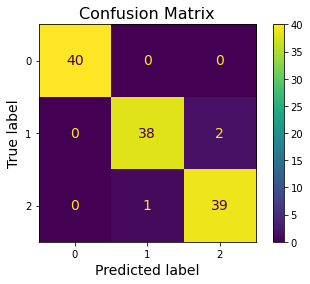

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

The classifier seems good, most of the numbers are on the diagonal. So these instances were classifed correctly.

The classifier seems to make 3 errors. (2 of class 1 classifed as 1 and 1 of class 2 classifed as 1). 

If we normalize the confusion matrix by rows we get the percentages of errors as opposed to the raw numbers

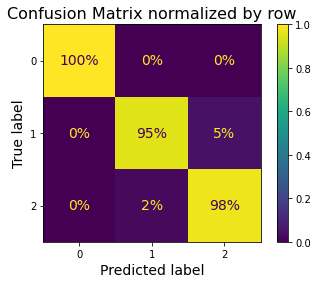

In [48]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        normalize="true", values_format=".0%")
plt.title("Confusion Matrix normalized by row", fontsize=16)

plt.show()

5% of instances from class 1 are misclassifed as class 2 and 2% of class 2 are misclassifed as class 1.

As we can see the confusion matrix is not symmetrical.

We can look at the instances that were misclassifed

In [49]:
misclassified_idx = y_train != y_train_pred
misclassified = X_train[misclassified_idx, :]


We can also plot them

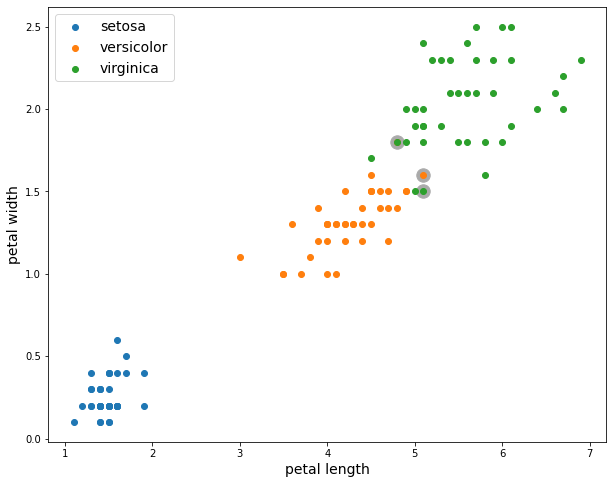

In [50]:
plt.figure(figsize=(10, 8))
for c in np.unique(y_train):
  plt.scatter(X_train[:, 2][y_train == c], 
              X_train[:, 3][y_train == c], 
              label=iris.target_names[c])
for m in misclassified:
  plt.scatter(m[2], m[3], s=180, zorder=-1, facecolors='#AAA')
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend()
plt.show()

The misclassified instances are close to the boundary between the classes